# Training sample model with DeiT: Data-efficient Image Transformer

## Useful soruces:

* [DeiT classifier for Cassava dataset](https://www.kaggle.com/huseynlilkin/cnn-or-transformer-pytorch-xla-tpu-for-cassava/edit)
* [Kaggle Utilty Script](https://www.kaggle.com/huseynlilkin/kaggle-pytorch-utility-script/edit?rvi=1)
* [Face-net Pytorch for face detection](https://www.kaggle.com/huseynlilkin/guide-to-mtcnn-in-facenet-pytorch/edit)
* [DeepFake starter kit](https://www.kaggle.com/huseynlilkin/deepfake-starter-kit/edit)
* [Has nice helper functions](https://www.kaggle.com/huseynlilkin/my-deep-fake-solution/edit)
* [LR reduce - good webiste](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/#reduce-on-loss-plateau-decay-patience0-factor01)
* [Selim's code](https://github.com/selimsef/dfdc_deepfake_challenge)
* [DeiT github page](https://github.com/facebookresearch/deit)
* [AffinityPropagation for clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation)

In [1]:
import os
import cv2
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.optim import Adam, SGD
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur, Resize, Normalize

from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import config

# Detection with DEiT

## Config

In [9]:
# CONFIG
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'deit_base_patch16_224' # other model names ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b3_ns']
LOAD_PRETRAINED = True
TARGET_SIZE = 2
LOAD_CHECKPOINT = True

LR = 1e-3
# lr scheduler
MODE = 'min'
FACTOR = 0.1
PATIENCE = 0

EPOCHS = 1
BATCH_SIZE = 48
NUM_WORKERS = 0 #os.cpu_count() - 1

## Dataset

In [3]:
class DFDCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.names = df['name'].values
        self.label_names = df['label'].values
        self.labels = np.where(self.label_names == 'REAL', 1, 0)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx]).long()
        
        file_name = self.names[idx]
        file_path = f'{config.root}/train_faces/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

## Transformers

In [ ]:
# Original transform functions from Selim's code
def create_train_transforms_by_selim(size=300):
    return Compose([
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        GaussianBlur(blur_limit=3, p=0.05),
        HorizontalFlip(),
        OneOf([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
        ], p=1),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ]
    )


def create_val_transforms_by_selim(size=300):
    return Compose([
        IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
    ])

In [4]:
def create_train_transforms(size=224):
    return Compose([
        Resize(224, 224),
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        GaussianBlur(blur_limit=3, p=0.05),
        HorizontalFlip(),
        # TODO: IsotropicResize
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), HueSaturationValue()], p=0.7), # FancyPCA() is missing
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

def create_val_transforms(size=224):
    return Compose([
        Resize(224, 224),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        ToTensorV2()
    ])

## Models

In [5]:
class DeiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', MODEL_NAME, pretrained=LOAD_PRETRAINED)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, TARGET_SIZE)
    
    def forward(self, x):
        return self.model(x)

- **TODO: CHECK HOW THEY TRAINED DEIT ORIGINALLY**
- **TODO: NEXT TIME, DOWNLOAD OTHER NOTEBOOK AND OPEN LOCALLY**

## Utils

In [6]:
class AverageMeter(object):
    """Computers and stores the average oand current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    

In [7]:
def save_checkpoint(model, optimizer, scheduler, scaler, epoch, loss, name='demo_local_train.tar'):
    path = 'D:/DFDC/models/' + name
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'loss': loss,
            }, path)
    

def load_checkpoint(path, model, optimizer, scheduler, scaler):
    checkpoint = torch.load(path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, scheduler, scaler, epoch, loss

## Train model

In [8]:
labels_df = pd.read_csv(f'{config.root}/labels.csv')

train_dataset = DFDCDataset(labels_df, create_train_transforms())
validation_dataset = DFDCDataset(labels_df, create_val_transforms())

train_loader = DataLoader(train_dataset, 
                         batch_size = BATCH_SIZE,
                         shuffle = True,
                         num_workers = NUM_WORKERS,
                         pin_memory = True,
                         drop_last = True)

validation_loader = DataLoader(validation_dataset, 
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         num_workers = NUM_WORKERS,
                         pin_memory = True,
                         drop_last = True)

c:\users\jonas\pycharmprojects\ilkinthesis\venv-thesis\lib\site-packages\albumentations\augmentations\transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [12]:
train_loss = []

model = DeiT()
model.to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer,  mode=MODE, factor=FACTOR, patience=PATIENCE, verbose=True)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

if LOAD_CHECKPOINT:
    model, optimizer, scheduler, scaler, epoch, loss = load_checkpoint('D:/DFDC/models/demo_local_train.tar', model, optimizer, scheduler, scaler)


for epoch in range(EPOCHS):
    for step, (images, labels) in enumerate(train_loader):
        if step % 100 == 0:
            print(f'Epoch: {epoch} Step: {step}/{len(train_loader)}')
            
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        batch_size = labels.size(0)
        
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            train_loss.append(loss.item())
            scaler.scale(loss).backward()
            # TODO: should we do gradient clipping here?
            # grad_norm = clip_grad_norm_(model.parameters, 1e-7)
            
            # TODO: what is a gradient accumulation?
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # TODO: Use validation loss instead
            scheduler.step(np.mean(train_loss))

Using cache found in C:\Users\Jonas/.cache\torch\hub\facebookresearch_deit_main


Epoch: 0 Step: 0/1225
Epoch: 0 Step: 100/1225
Epoch: 0 Step: 200/1225
Epoch: 0 Step: 300/1225
Epoch: 0 Step: 400/1225
Epoch: 0 Step: 500/1225
Epoch: 0 Step: 600/1225
Epoch: 0 Step: 700/1225
Epoch: 0 Step: 800/1225
Epoch: 0 Step: 900/1225
Epoch: 0 Step: 1000/1225
Epoch: 0 Step: 1100/1225
Epoch: 0 Step: 1200/1225


20 epochs 2h 40m 

Training completed: average loss: 0.40740308402144176


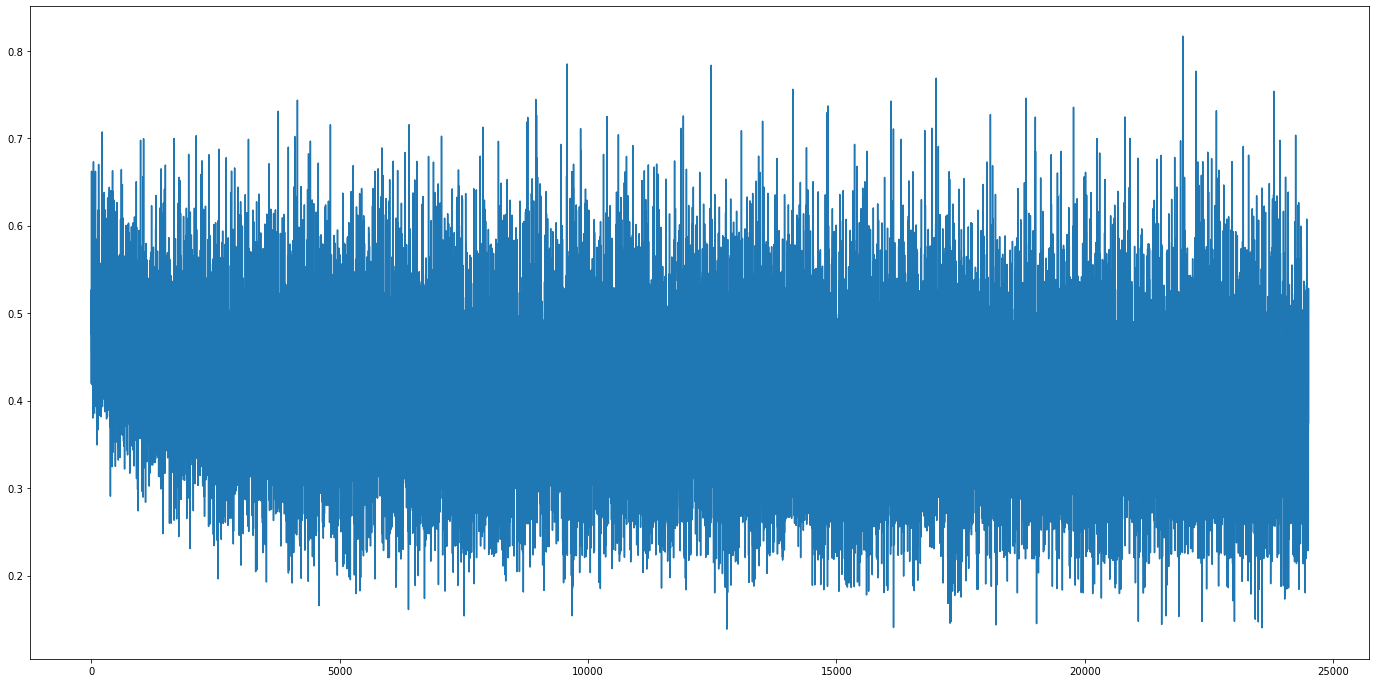

In [26]:
plt.figure(figsize=(24,12))
print(f"Training completed: average loss: {np.mean(train_loss)}")
plt.plot(train_loss)

In [28]:
save_checkpoint(model, optimizer, scheduler, scaler, epoch, loss, name='p1and48_e20.tar')